# B2. Cyber Threat Detection Using Deep Learning

Cyber threats are a growing concern for organizations worldwide. These threats take many forms, including malware, phishing, and denial-of-service (DOS) attacks, compromising sensitive information and disrupting operations. The increasing sophistication and frequency of these attacks make it imperative for organizations to adopt advanced security measures. Traditional threat detection methods often fall short due to their inability to adapt to new and evolving threats. This is where deep learning models come into play.

Deep learning models can analyze vast amounts of data and identify patterns that may not be immediately obvious to human analysts. By leveraging these models, organizations can proactively detect and mitigate cyber threats, safeguarding their sensitive information and ensuring operational continuity.

As a cybersecurity analyst, you identify and mitigate these threats. In this project, you will design and implement a deep learning model to detect cyber threats. The BETH dataset simulates real-world logs, providing a rich source of information for training and testing your model. The data has already undergone preprocessing, and we have a target label, `sus_label`, indicating whether an event is malicious (1) or benign (0).

By successfully developing this model, you will contribute to enhancing cybersecurity measures and protecting organizations from potentially devastating cyber attacks.


### The Data

| Column     | Description              |
|------------|--------------------------|
|`processId`|The unique identifier for the process that generated the event - int64 |
|`threadId`|ID for the thread spawning the log - int64|
|`parentProcessId`|Label for the process spawning this log - int64|
|`userId`|ID of user spawning the log|Numerical - int64|
|`mountNamespace`|Mounting restrictions the process log works within - int64|
|`argsNum`|Number of arguments passed to the event - int64|
|`returnValue`|Value returned from the event log (usually 0) - int64|
|`sus_label`|Binary label as suspicous event (1 is suspicious, 0 is not) - int64|

More information on the dataset: [BETH dataset](accreditation.md)

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import accuracy_score


In [ ]:
# Load preprocessed data
train_df = pd.read_csv('labelled_train.csv')
# test_df = pd.read_csv('labelled_test.csv')
val_df = pd.read_csv('labelled_validation.csv')

# View the first 5 rows of training set
train_df.head()

,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,7337,1,100,4026532231,5,0,1
1,381,7337,1,100,4026532231,1,0,1
2,381,7337,1,100,4026532231,0,0,1
3,7347,7347,7341,0,4026531840,2,-2,1
4,7347,7347,7341,0,4026531840,4,0,1


In [ ]:
total_df = pd.concat([train_df, val_df], axis=0)

In [ ]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952111 entries, 0 to 188966
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   processId        952111 non-null  int64
 1   threadId         952111 non-null  int64
 2   parentProcessId  952111 non-null  int64
 3   userId           952111 non-null  int64
 4   mountNamespace   952111 non-null  int64
 5   argsNum          952111 non-null  int64
 6   returnValue      952111 non-null  int64
 7   sus_label        952111 non-null  int64
dtypes: int64(8)
memory usage: 65.4 MB


# Data Exploration

In [ ]:
total_df.isnull().sum()/len(total_df)

,0
processId,0.0
threadId,0.0
parentProcessId,0.0
userId,0.0
mountNamespace,0.0
argsNum,0.0
returnValue,0.0
sus_label,0.0


In [ ]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952111 entries, 0 to 188966
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   processId        952111 non-null  int64
 1   threadId         952111 non-null  int64
 2   parentProcessId  952111 non-null  int64
 3   userId           952111 non-null  int64
 4   mountNamespace   952111 non-null  int64
 5   argsNum          952111 non-null  int64
 6   returnValue      952111 non-null  int64
 7   sus_label        952111 non-null  int64
dtypes: int64(8)
memory usage: 65.4 MB


In [ ]:
for column in total_df.columns:
    print(f'{column}: {total_df[column].value_counts()}')

processId: processId
159     22079
1       20892
187      8554
7277     7868
7296     7687
        ...  
7155        1
1631        1
268         1
1392        1
2698        1
Name: count, Length: 589, dtype: int64
threadId: threadId
159     21965
1       20892
187      8554
7277     7868
7296     7687
        ...  
7157        1
7184        1
7185        1
2698        1
650         1
Name: count, Length: 644, dtype: int64
parentProcessId: parentProcessId
187     261959
1        72083
7099     66480
1469     62274
188      59649
         ...  
7147         1
7141         1
7150         1
7140         1
7139         1
Name: count, Length: 218, dtype: int64
userId: userId
0       942532
101       3656
1000      1773
109       1476
102       1394
100       1214
103         66
Name: count, dtype: int64
mountNamespace: mountNamespace
4026531840    612501
4026532217    332402
4026532232      3656
4026532229      1394
4026532231      1214
4026532288       944
Name: count, dtype: int64
argsNum:

unbalanced target classes


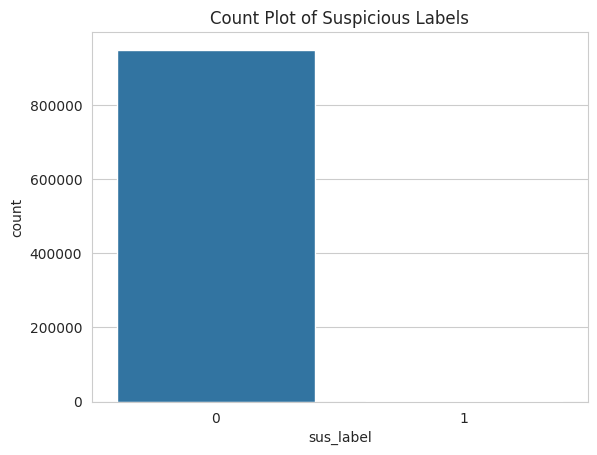

In [ ]:
# prompt: give me count plot for the temp df

# Assuming 'temp_df' is already defined as in the provided code.
sns.countplot(x='sus_label', data=total_df)
plt.title('Count Plot of Suspicious Labels')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_all_columns(df):
    sns.set_style("whitegrid")
    missing_summary = {}
    unique_summary = []

    # Columns to treat as discrete/categorical
    discrete_columns = {'threadId', 'processId', 'parentProcessId', 'userId', 'sus_label'}

    for column_name in df.columns:
        print(f"\n{'=' * 60}")
        print(f"Analyzing column: '{column_name}'")
        print(f"{'=' * 60}\n")

        # Missing Values
        missing_values = df[column_name].isnull().sum()
        if missing_values > 0:
            missing_summary[column_name] = missing_values
        print(f"Missing values in '{column_name}': {missing_values}")

        # Duplicates
        duplicates = df.duplicated(subset=[column_name]).sum()
        print(f"Number of duplicate '{column_name}' entries: {duplicates}")

        # Unique Values
        unique_values = df[column_name].nunique()
        print(f"Number of unique '{column_name}': {unique_values}")

        if unique_values == len(df):
            unique_summary.append(column_name)
            print(f"'{column_name}' is completely unique; skipping further analysis.")
        else:
            is_discrete = (
                column_name in discrete_columns or
                df[column_name].dtype in ['object', 'category', 'bool']
            )

            if is_discrete:
                value_counts = df[column_name].value_counts()

                if unique_values <= 13:
                    print(f"All unique values with counts in '{column_name}':\n{value_counts}\n")
                    top_categories = value_counts.index
                else:
                    print(f"Top 5 most common values in '{column_name}':\n{value_counts.head(5)}\n")
                    top_categories = value_counts.index[:5]

                # Visualize value counts (bar chart with count on y-axis)
                plt.figure(figsize=(10, 6))
                sns.barplot(
                    x=top_categories.astype(str),
                    y=value_counts.loc[top_categories].values,
                    palette="viridis"
                )
                plt.title(f"Top {len(top_categories)} Values in '{column_name}'", fontsize=16, fontweight='bold', pad=15)
                plt.ylabel("Count", fontsize=12, labelpad=10)
                plt.xlabel(column_name, fontsize=12, labelpad=10)
                plt.xticks(rotation=45)
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.show()

            else:
                # Numerical Column Distribution
                print(f"Distribution of '{column_name}':\n{df[column_name].describe()}\n")

                # Histogram & KDE
                plt.figure(figsize=(10, 6))
                sns.histplot(df[column_name].dropna(), bins=30, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
                sns.kdeplot(df[column_name].dropna(), color='darkblue', linewidth=2, label='KDE')
                plt.title(f"Distribution of {column_name}", fontsize=16, fontweight='bold', pad=15)
                plt.xlabel(column_name, fontsize=12, labelpad=10)
                plt.ylabel("Frequency", fontsize=12, labelpad=10)
                plt.legend(fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.show()

                # Outlier Detection
                Q1 = df[column_name].quantile(0.25)
                Q3 = df[column_name].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)][column_name]
                print(f"Outliers in '{column_name}': {len(outliers)} entries")
                if len(outliers) > 0:
                    print(f"Sample outliers:\n{outliers.head(10)}\n")
                print(f"IQR lower bound: {lower_bound}, upper bound: {upper_bound}\n")

                # Boxplot
                plt.figure(figsize=(10, 6))
                sns.boxplot(x=df[column_name], color='orange', showmeans=True)
                plt.title(f"Outliers in {column_name}", fontsize=16, fontweight='bold', pad=15)
                plt.xlabel(column_name, fontsize=12, labelpad=10)
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.tight_layout()
                plt.show()

        print("\n\n")

    # Summary
    print(f"\n\n{'=' * 60}")
    print(f"{' ' * 25} SUMMARY")
    print(f"{'=' * 60}\n")

    if missing_summary:
        print("Summary of columns with missing values:")
        print("-" * 40)
        for col, missing_count in missing_summary.items():
            print(f"Column: {col}, Missing Values: {missing_count}")
    else:
        print("No missing values found in any column.")

    if unique_summary:
        print("\nSummary of completely unique columns:")
        print("-" * 40)
        for col in unique_summary:
            print(f"Column: {col} is completely unique.")
    else:
        print("\nNo completely unique columns found.")



# analyze_all_columns(total_df)

<ipython-input-215-ee6df540a4d5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette="coolwarm")


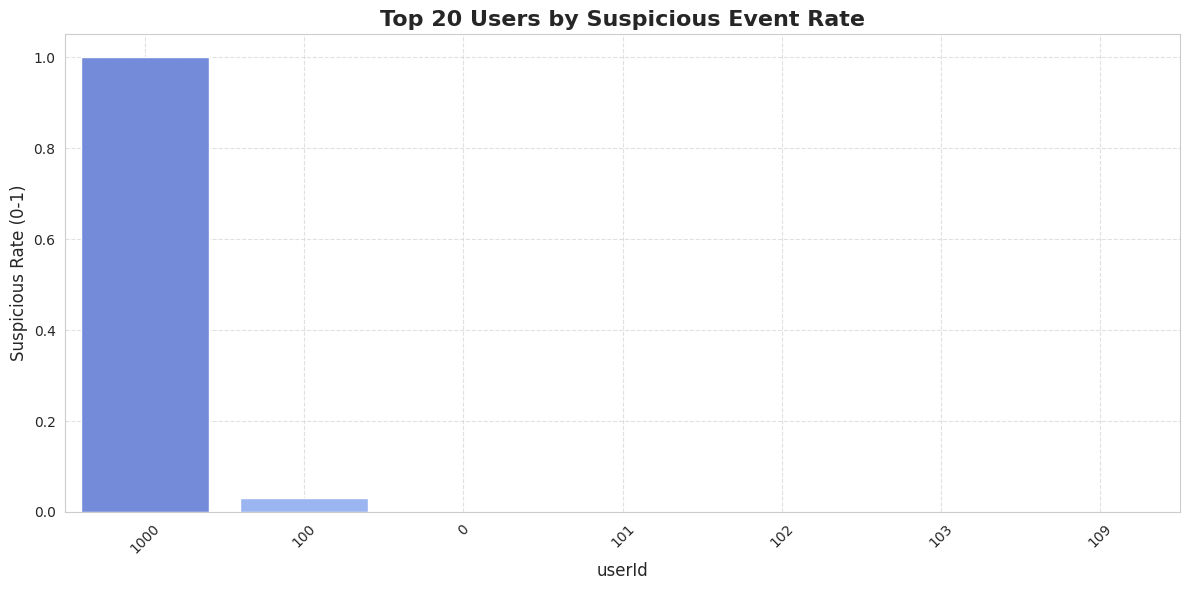

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_suspicion_rate_by_user(df, top_n=20):
    # Group by userId and calculate the mean of sus_label (i.e., suspicion rate)
    suspicion_rate = df.groupby('userId')['sus_label'].mean().sort_values(ascending=False)

    # Get top N most suspicious users
    top_users = suspicion_rate.head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette="coolwarm")
    plt.title(f"Top {top_n} Users by Suspicious Event Rate", fontsize=16, fontweight='bold')
    plt.xlabel("userId", fontsize=12)
    plt.ylabel("Suspicious Rate (0-1)", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Usage
plot_suspicion_rate_by_user(train_df, top_n=20)


# Data Preparation

In [ ]:
total_df = total_df.dropna()

In [ ]:
total_df.head()

,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,7337,1,100,4026532231,5,0,1
1,381,7337,1,100,4026532231,1,0,1
2,381,7337,1,100,4026532231,0,0,1
3,7347,7347,7341,0,4026531840,2,-2,1
4,7347,7347,7341,0,4026531840,4,0,1


In [ ]:
duplicate_count = total_df.duplicated().sum()/total_df.shape[0]
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0.980516977537283


In [ ]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952111 entries, 0 to 188966
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   processId        952111 non-null  int64
 1   threadId         952111 non-null  int64
 2   parentProcessId  952111 non-null  int64
 3   userId           952111 non-null  int64
 4   mountNamespace   952111 non-null  int64
 5   argsNum          952111 non-null  int64
 6   returnValue      952111 non-null  int64
 7   sus_label        952111 non-null  int64
dtypes: int64(8)
memory usage: 65.4 MB


In [ ]:
total_df= total_df.drop_duplicates()
total_df.shape[0]

18550


Analyzing column: 'processId'

Missing values in 'processId': 0
Number of duplicate 'processId' entries: 17961
Number of unique 'processId': 589
Top 5 most common values in 'processId':
processId
187     217
159     138
1378    136
7099    133
7371    126
Name: count, dtype: int64



<ipython-input-214-843e70943cf6>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


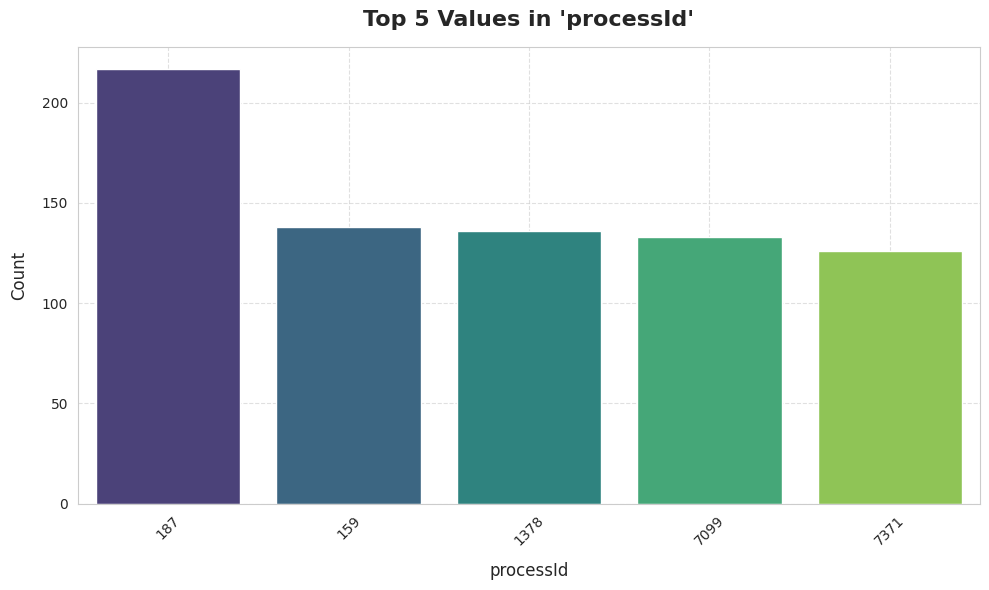

<ipython-input-214-843e70943cf6>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(






Analyzing column: 'threadId'

Missing values in 'threadId': 0
Number of duplicate 'threadId' entries: 17906
Number of unique 'threadId': 644
Top 5 most common values in 'threadId':
threadId
187     217
7099    133
7371    126
7400    123
7390    121
Name: count, dtype: int64



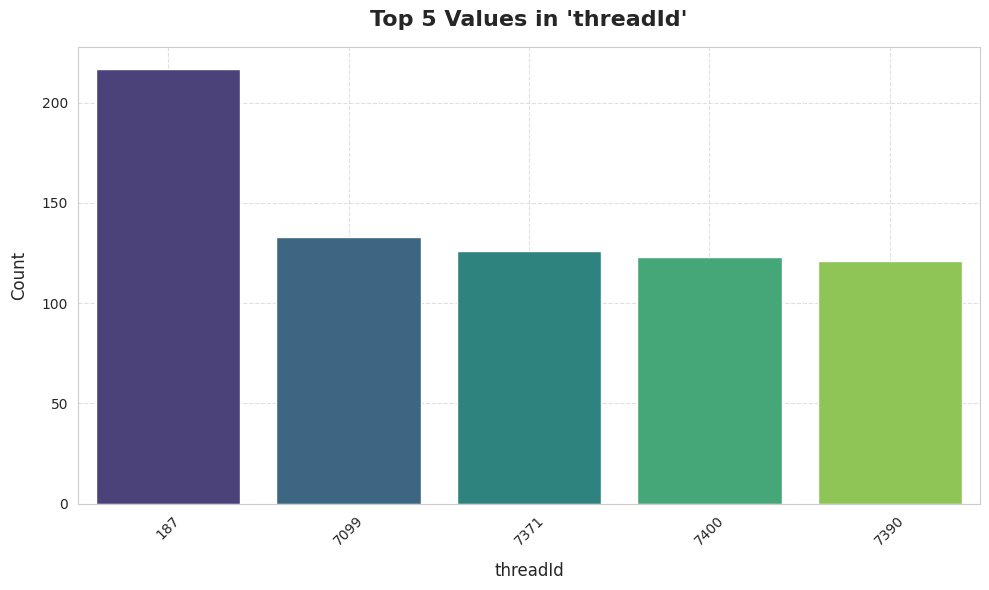

<ipython-input-214-843e70943cf6>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(






Analyzing column: 'parentProcessId'

Missing values in 'parentProcessId': 0
Number of duplicate 'parentProcessId' entries: 18332
Number of unique 'parentProcessId': 218
Top 5 most common values in 'parentProcessId':
parentProcessId
7099    3649
1       2180
187     2087
188     1158
1469     855
Name: count, dtype: int64



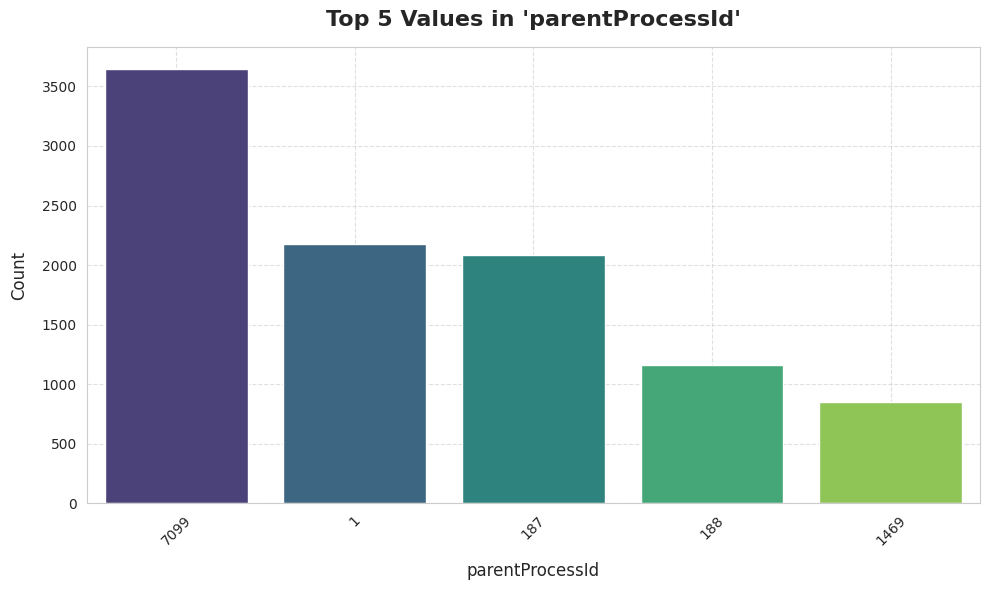

<ipython-input-214-843e70943cf6>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(






Analyzing column: 'userId'

Missing values in 'userId': 0
Number of duplicate 'userId' entries: 18543
Number of unique 'userId': 7
All unique values with counts in 'userId':
userId
0       17657
109       612
1000      102
100        88
101        46
102        25
103        20
Name: count, dtype: int64



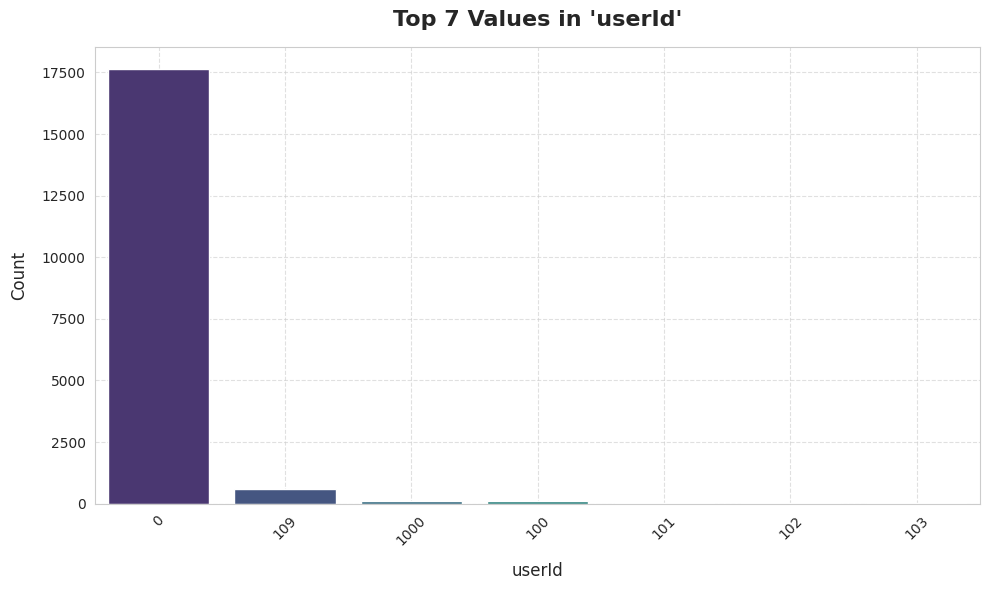





Analyzing column: 'mountNamespace'

Missing values in 'mountNamespace': 0
Number of duplicate 'mountNamespace' entries: 18544
Number of unique 'mountNamespace': 6
Distribution of 'mountNamespace':
count    1.855000e+04
mean     4.026532e+09
std      1.531915e+02
min      4.026532e+09
25%      4.026532e+09
50%      4.026532e+09
75%      4.026532e+09
max      4.026532e+09
Name: mountNamespace, dtype: float64



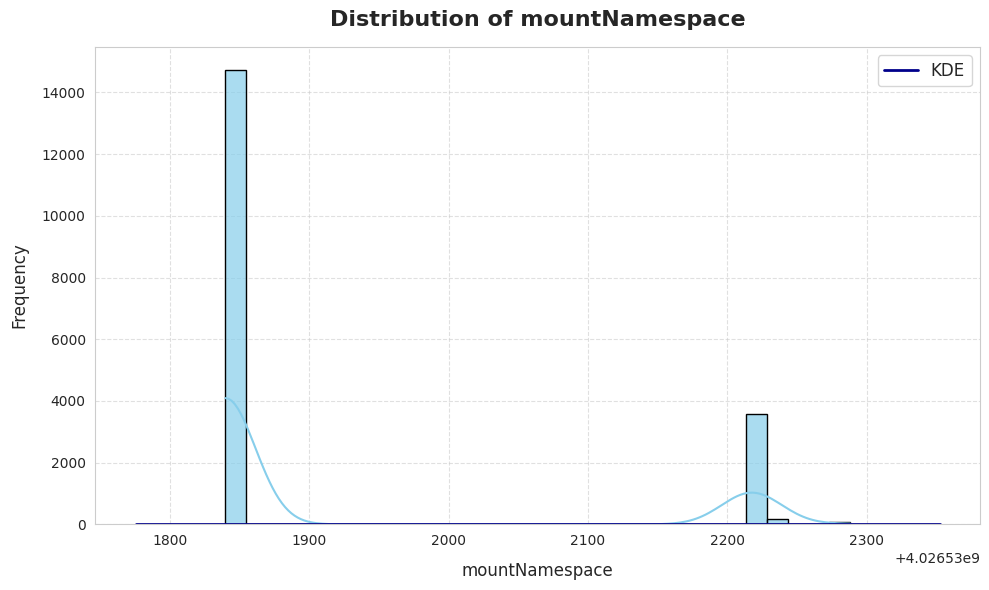

Outliers in 'mountNamespace': 3811 entries
Sample outliers:
0     4026532231
1     4026532231
2     4026532231
36    4026532231
37    4026532231
38    4026532231
73    4026532231
74    4026532231
75    4026532231
76    4026532231
Name: mountNamespace, dtype: int64

IQR lower bound: 4026531840.0, upper bound: 4026531840.0



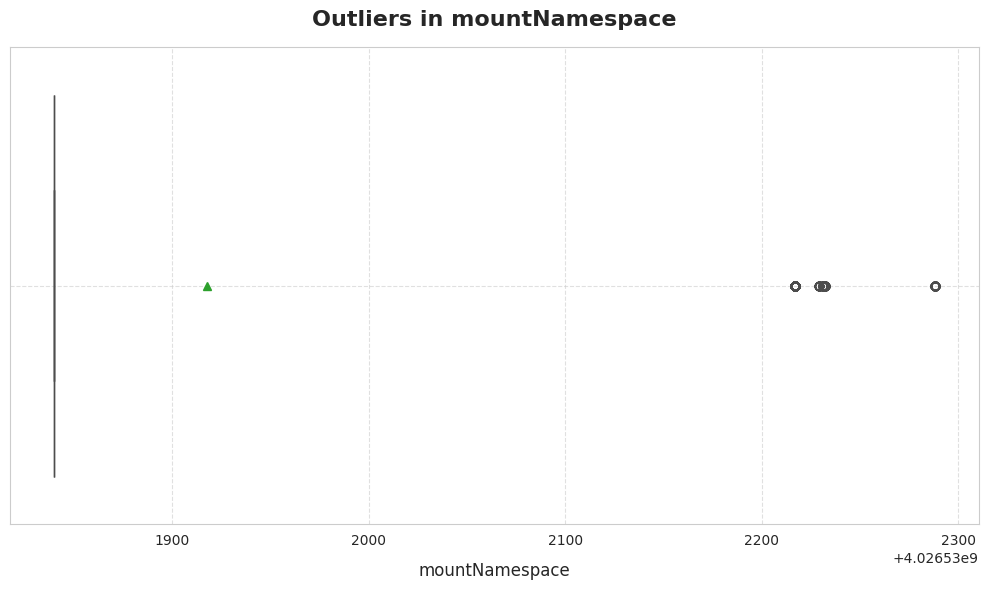





Analyzing column: 'argsNum'

Missing values in 'argsNum': 0
Number of duplicate 'argsNum' entries: 18544
Number of unique 'argsNum': 6
Distribution of 'argsNum':
count    18550.000000
mean         2.872776
std          1.412416
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: argsNum, dtype: float64



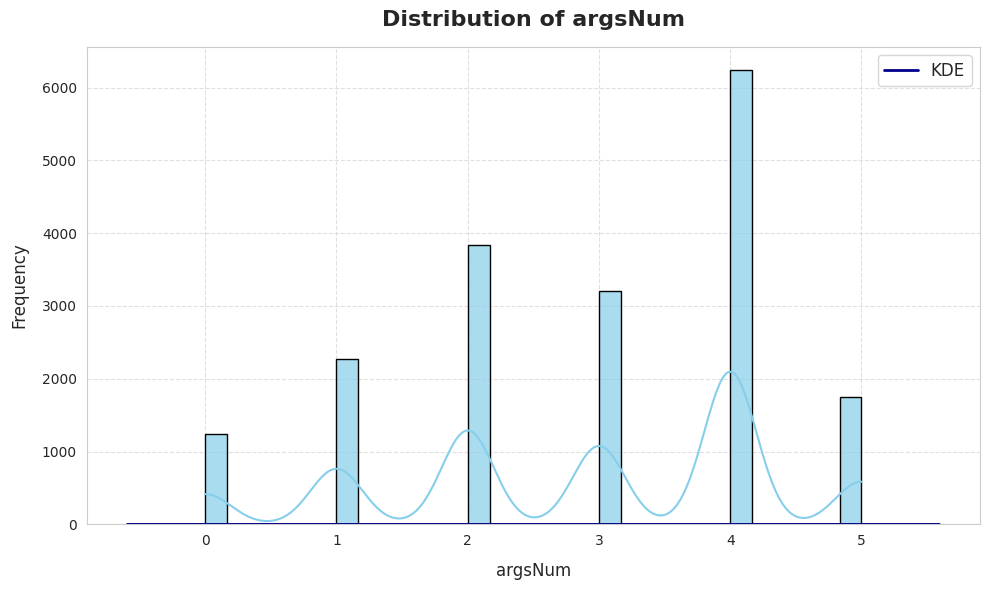

Outliers in 'argsNum': 0 entries
IQR lower bound: -1.0, upper bound: 7.0



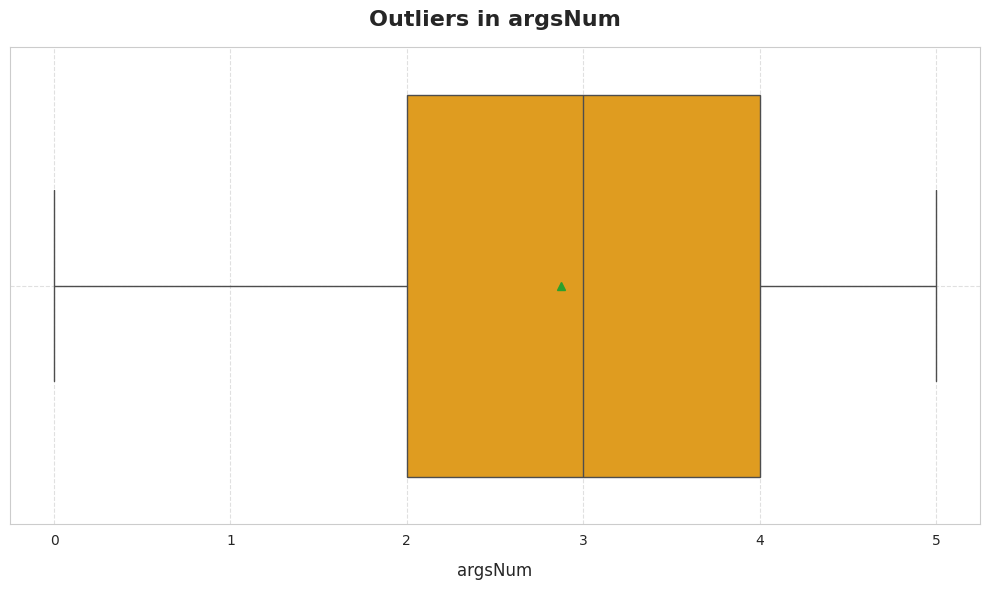





Analyzing column: 'returnValue'

Missing values in 'returnValue': 0
Number of duplicate 'returnValue' entries: 18017
Number of unique 'returnValue': 533
Distribution of 'returnValue':
count    18550.000000
mean       565.356173
std       1877.255944
min       -115.000000
25%          0.000000
50%          0.000000
75%          6.000000
max       8289.000000
Name: returnValue, dtype: float64



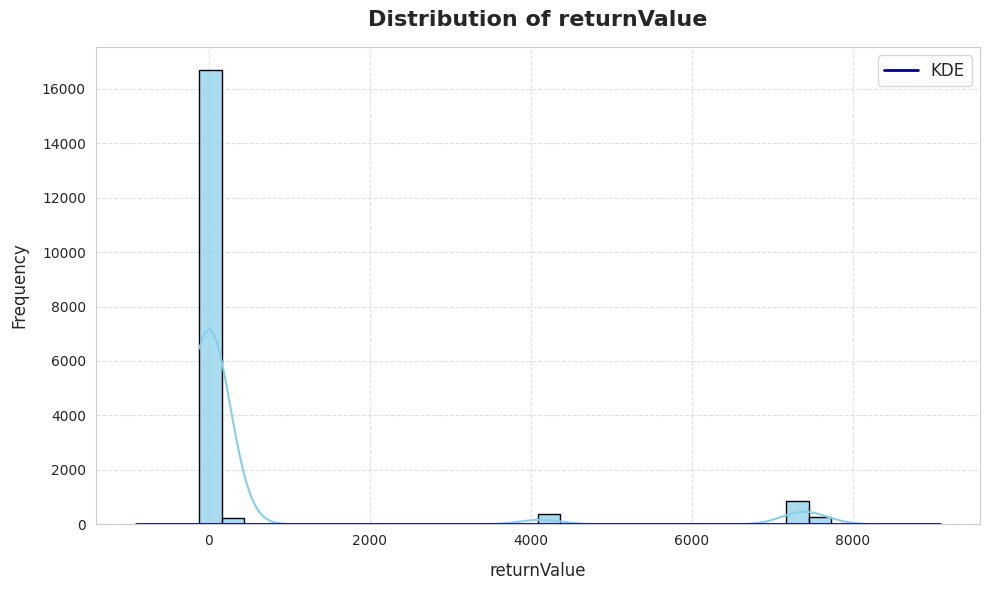

Outliers in 'returnValue': 2478 entries
Sample outliers:
16     7348
31       80
53     7342
68       80
93     7353
108      80
136    7384
151      80
176    7391
191      80
Name: returnValue, dtype: int64

IQR lower bound: -9.0, upper bound: 15.0



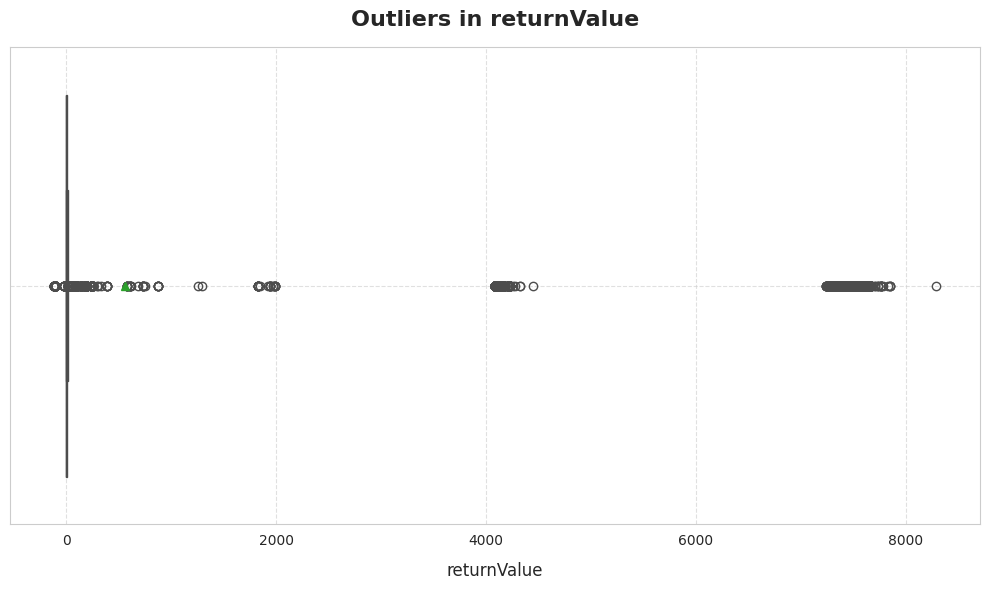





Analyzing column: 'sus_label'

Missing values in 'sus_label': 0
Number of duplicate 'sus_label' entries: 18548
Number of unique 'sus_label': 2
All unique values with counts in 'sus_label':
sus_label
0    18303
1      247
Name: count, dtype: int64



<ipython-input-214-843e70943cf6>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


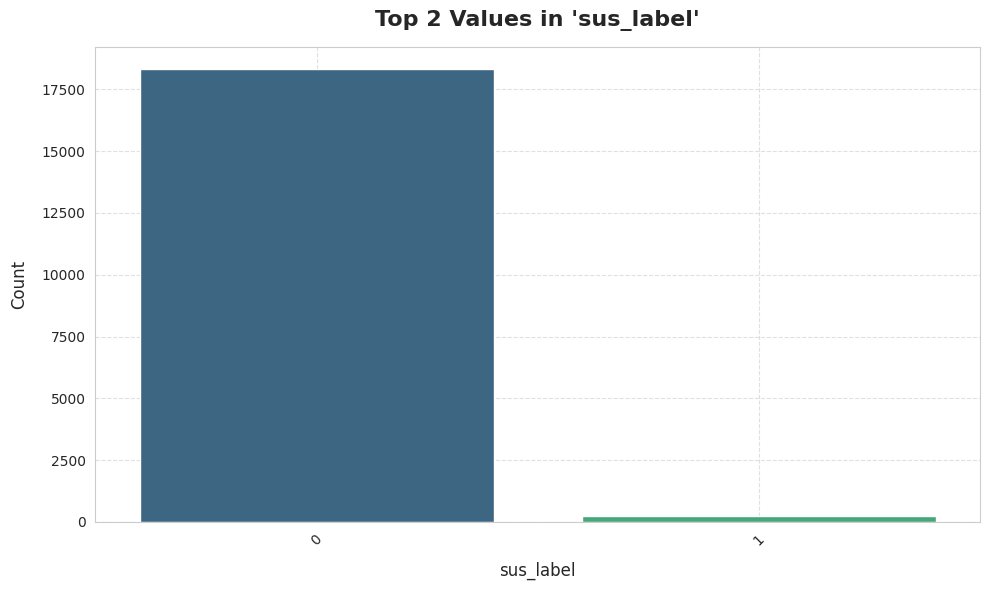






                          SUMMARY

No missing values found in any column.

No completely unique columns found.


In [ ]:
analyze_all_columns(total_df)

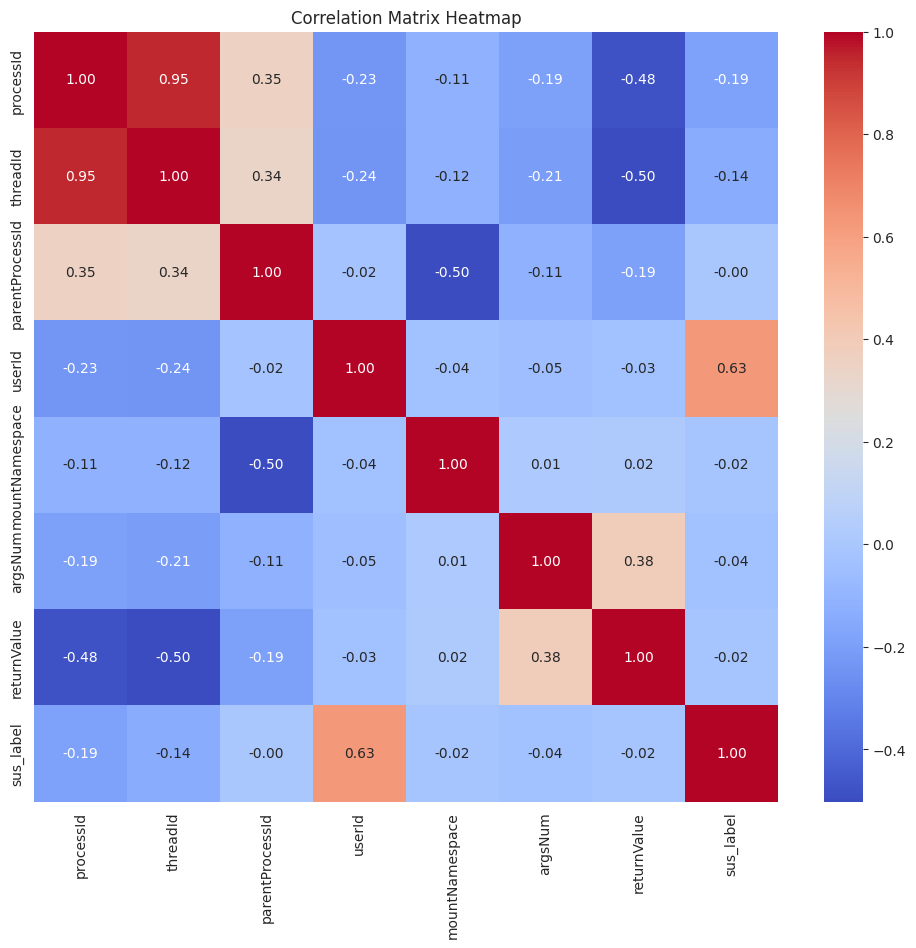

In [ ]:
# Calculate the correlation matrix
correlation_matrix = total_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


In [ ]:
total_df = total_df.drop(['processId', 'userId'], axis=1)
total_df.head()

,threadId,parentProcessId,mountNamespace,argsNum,returnValue,sus_label
0,7337,1,4026532231,5,0,1
1,7337,1,4026532231,1,0,1
2,7337,1,4026532231,0,0,1
3,7347,7341,4026531840,2,-2,1
4,7347,7341,4026531840,4,0,1


## Splitting 70-15-15

In [ ]:
# prompt: from temp_df create train_df, val_df, test_df with percentages 70, 15, 15

# Calculate the number of samples for each set
n_samples = len(total_df)
n_train = int(0.7 * n_samples)
n_val = int(0.15 * n_samples)
n_test = n_samples - n_train - n_val

# Shuffle the DataFrame
shuffled_df = total_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create the train, validation, and test sets
train_df = shuffled_df[:n_train]
val_df = shuffled_df[n_train:n_train + n_val]
test_df = shuffled_df[n_train + n_val:]

# Print the shapes of the resulting DataFrames
print("Train set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (12985, 6)
Validation set shape: (2782, 6)
Test set shape: (2783, 6)


In [ ]:
total_df = pd.concat([train_df, val_df, test_df], axis=0)
train_perc = train_df.shape[0]/total_df.shape[0]
val_perc = val_df.shape[0]/total_df.shape[0]
test_perc = test_df.shape[0]/total_df.shape[0]

print(train_perc)
print(val_perc)
print(test_perc)
print(train_perc + val_perc + test_perc)

0.7
0.1499730458221024
0.15002695417789758
1.0


## normalization


In [ ]:
X_train = train_df.drop('sus_label', axis=1)
y_train = train_df['sus_label']
X_val = val_df.drop('sus_label', axis=1)
y_val = val_df['sus_label']
X_test = test_df.drop('sus_label', axis=1)
y_test = test_df['sus_label']

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# Create the Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

# 1. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# 2. Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# 3. Define Feedforward Neural Network
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No sigmoid here (handled in loss)
        return x

model = FFNN(input_dim=X_train_tensor.shape[1])

# 4. Set up optimizer and loss
# Handle class imbalance with pos_weight if needed
# Example: pos_weight = torch.tensor([weight_for_1])
pos_weight = torch.tensor([y_train_tensor.shape[0] / y_train_tensor.sum()])  # weight > 1
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Train the Model

In [ ]:
"""# 5. Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

# 6. Evaluation on Test Set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_probs = torch.sigmoid(test_outputs)
    test_preds = (test_probs > 0.5).int()

# 7. Report Results
print("\nClassification Report:")
print(classification_report(y_test_tensor.int(), test_preds))"""
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()

        # Use 'criterion' instead of 'loss_function'
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # ===== Accuracy Calculation =====
        predictions = torch.sigmoid(outputs) > 0.5
        correct += (predictions.int() == y_batch.int()).sum().item()
        total += y_batch.size(0)
        # =================================

    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")

Epoch 1/20 - Loss: 241.2432 - Accuracy: 0.8209
Epoch 2/20 - Loss: 180.4051 - Accuracy: 0.7073
Epoch 3/20 - Loss: 166.6208 - Accuracy: 0.7427
Epoch 4/20 - Loss: 159.7576 - Accuracy: 0.7770
Epoch 5/20 - Loss: 153.5751 - Accuracy: 0.7964
Epoch 6/20 - Loss: 145.1499 - Accuracy: 0.8015
Epoch 7/20 - Loss: 145.8717 - Accuracy: 0.8067
Epoch 8/20 - Loss: 136.8517 - Accuracy: 0.8213
Epoch 9/20 - Loss: 134.3156 - Accuracy: 0.8115
Epoch 10/20 - Loss: 129.9875 - Accuracy: 0.8178
Epoch 11/20 - Loss: 125.8940 - Accuracy: 0.8239
Epoch 12/20 - Loss: 122.6846 - Accuracy: 0.8229
Epoch 13/20 - Loss: 118.6637 - Accuracy: 0.8297
Epoch 14/20 - Loss: 113.7498 - Accuracy: 0.8271
Epoch 15/20 - Loss: 113.7389 - Accuracy: 0.8354
Epoch 16/20 - Loss: 110.7598 - Accuracy: 0.8365
Epoch 17/20 - Loss: 106.2888 - Accuracy: 0.8412
Epoch 18/20 - Loss: 108.2686 - Accuracy: 0.8270
Epoch 19/20 - Loss: 105.6255 - Accuracy: 0.8397
Epoch 20/20 - Loss: 107.2001 - Accuracy: 0.8392
